<a href="https://colab.research.google.com/github/TongQM/SONAR_VLM/blob/main/sonar_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install SONAR embeddings and requirements

In [ ]:
!pip -q install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.5 MB/s eta 0:00:00


In [ ]:
!pip show torch
!pip install fairseq2 --extra-index-url https://fair.pkg.atmeta.com/fairseq2/whl/pt2.6.0/cu124
!pip install sonar-space

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchvision
Looking in indexes: https://pypi.org/simple, https://fair.pkg.atmeta.com/fairseq2/whl/pt2.6.0/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'sox' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'sox'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for sox: filename=sox-1.5.0-py3-none-any.whl size=40036 sha256=27635e0db338f170b7930ddf00c738dd281e3f09880e9d384302a703398503bc
  Stored in directory: /root/.cache/pip/wheels/74/89/93/023fcdacaec4e5471e78b43992515e8500cc2505b307e2e6b7
Successfully built sox
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [sonar-space]


# Mount Google drive and set work directory

In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('/content/')

Mounted at /content/gdrive


## Download Data

In [ ]:
!mkdir images
%cd images
# # Download the images from the COCO dataset
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/zips/test2017.zip
# wget http://images.cocodataset.org/zips/unlabeled2017.zip

# Unzip the images
!unzip -q train2017.zip
!unzip -q val2017.zip
!unzip -q test2017.zip
# unzip unlabeled2017.zip

# # Remove the zip files
# !rm train2017.zip
# !rm val2017.zip
# !rm test2017.zip
# !rm unlabeled2017.zip

# # Download the annotations from the COCO dataset
%cd ../
!mkdir annotations
%cd annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
!wget http://images.cocodataset.org/annotations/image_info_test2017.zip
# wget http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip

# # Unzip the annotations
!unzip -q annotations_trainval2017.zip
# unzip stuff_annotations_trainval2017.zip
!unzip -q image_info_test2017.zip
# unzip image_info_unlabeled2017.zip

# # Remove the zip files
# !rm annotations_trainval2017.zip
# !rm stuff_annotations_trainval2017.zip
# !rm image_info_test2017.zip
# !rm image_info_unlabeled2017.zip

/content/images
--2025-04-30 02:59:06--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.206.99, 3.5.25.93, 3.5.27.153, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.206.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  18.1MB/s    in 30m 0s  

2025-04-30 03:29:07 (10.2 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2025-04-30 03:29:07--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.29.148, 54.231.170.41, 3.5.31.118, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.29.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 

In [ ]:
!pip install torchinfo

### Import necessary packages

In [ ]:
import json
import torch
import random
import torch.nn as nn
import os
import gc
import math
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn import CosineEmbeddingLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models import resnet50, resnet152, ResNet152_Weights, ResNet50_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights, vit_l_16, ViT_L_16_Weights
from torchinfo import summary

from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline
from sonar.inference_pipelines.text import EmbeddingToTextModelPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'mps' if torch.backends.mps.is_available() else device
print(f"Using device: {device}")

Using device: cuda


## Load text2embedding model

In [ ]:
t2vec_model = TextToEmbeddingModelPipeline(encoder="text_sonar_basic_encoder",
                                           tokenizer="text_sonar_basic_encoder",
                                           device=torch.device(device),
                                           dtype=torch.float16)
sentences = ['I want to get an intern offer pls', 'I wish myself good luck']
embeddings = t2vec_model.predict(sentences, source_lang="eng_Latn")


vec2text_model = EmbeddingToTextModelPipeline(decoder="text_sonar_basic_decoder",
                                              tokenizer="text_sonar_basic_encoder",
                                              device=torch.device(device),
                                              dtype=torch.float16)
reconstructed = vec2text_model.predict(embeddings, target_lang="eng_Latn", max_seq_len=512)
print("Original sentences:")
for sentence in sentences:
    print(sentence)
print("\nReconstructed sentences:")
for sentence in reconstructed:
    print(sentence)

100%|██████████| 2.85G/2.85G [00:14<00:00, 216MB/s]
100%|██████████| 4.63M/4.63M [00:00<00:00, 200MB/s]
100%|██████████| 4.21G/4.21G [00:33<00:00, 133MB/s]


Original sentences:
I want to get an intern offer pls
I wish myself good luck

Reconstructed sentences:
I want to get an internship offer pls
I wish myself good luck


## Load train and validation data

### Precompute the embeddings of captions for each image

In [ ]:
import json
import torch
from collections import defaultdict
from tqdm import tqdm

def precompute_caption_embeddings(
    coco_json: str,
    text_encoder,
    output_path: str,
    numcaps: int = 5,
    batch_size: int = 512,
    device: str = "cpu",
):
    """
    Reads the COCO captions JSON, groups & truncates to `numcaps` per image,
    encodes *all* captions through your text_encoder, then splits them back
    into a dict mapping `"<image_id>.jpg"` → Tensor of shape (numcaps, D),
    and torch.saves that dict to `output_path`.
    """
    # 1) load & group captions
    with open(coco_json) as f:
        coco = json.load(f)
    caps = defaultdict(list)
    for ann in coco["annotations"]:
        key = f"{ann['image_id']:012d}.jpg"
        caps[key].append(ann["caption"])
    # truncate
    for k in caps:
        caps[k] = sorted(caps[k])[:numcaps]

    # 2) flatten all captions
    items   = list(caps.items())                # [(img_name, [cap1,…]), …]
    all_caps = [cap for _, clist in items for cap in clist]

    # 3) encode in batches for memory‐efficiency
    text_encoder.to(device).eval()
    all_embs = []
    with torch.no_grad():
        for i in tqdm(range(0, len(all_caps), batch_size)):
            batch = all_caps[i : i + batch_size]
            emb = text_encoder.predict(batch, source_lang="eng_Latn")
            emb = torch.as_tensor(emb) if not isinstance(emb, torch.Tensor) else emb
            all_embs.append(emb.cpu())
    all_embs = torch.cat(all_embs, dim=0)       # (sum(counts), D)

    # 4) split back per image
    embedding_map = {}
    idx = 0
    D   = all_embs.size(1)
    for img_name, clist in items:
        m = len(clist)
        embedding_map[img_name] = all_embs[idx : idx + m]  # (m, D)
        idx += m

    # 5) save to disk
    torch.save(embedding_map, output_path)

In [ ]:
precompute_caption_embeddings(
    coco_json     = "./data/captions_val2017.json",
    text_encoder  = t2vec_model,
    output_path   = "/content/coco2017_valcaption_embs.pt",
    numcaps       = 5,
    batch_size    = 1024,
    device        = device,
)

In [ ]:
# Load valcaption_embs
val_caption_embs = torch.load("/content/gdrive/MyDrive/sonar/maps/coco2017_valcaption_embs.pt")
sample_embs = val_caption_embs['000000519491.jpg']

# The original captions
with open("./annotations/captions_val2017.json") as f:
    coco = json.load(f)
    caps = defaultdict(list)
    for ann in coco["annotations"]:
        key = f"{ann['image_id']:012d}.jpg"
        caps[key].append(ann["caption"])

image_id = "000000519491.jpg"
print(f"Image ID: {image_id}")

img = Image.open(f"./images/val2017/{image_id}")
plt.imshow(img)
plt.show()

# Compare the original captions and deciphered captions
for cap in caps['000000519491.jpg']:
    print(f"Original caption: {cap}")

reconstructed = vec2text_model.predict(sample_embs, target_lang="eng_Latn", max_seq_len=512)
for cap in reconstructed:
    print(f"Reconstructed caption: {cap}")

In [ ]:
# Download coco2017_valcaption_embs.pt
from google.colab import files
files.download('/content/coco2017_valcaption_embs.pt')

In [ ]:
precompute_caption_embeddings(
    coco_json     = "./data/captions_train2017.json",
    text_encoder  = t2vec_model,
    output_path   = "/content/coco2017_traincaption_embs.pt",
    numcaps       = 5,
    batch_size    = 1024,
    device        = device,
)

In [ ]:
files.download('/content/coco2017_traincaption_embs.pt')

### Define dataloader with SONAR embeddings as labels

In [ ]:
class COCOCaptionTextDataset(Dataset):
    """
    Returns (image_tensor, list_of_captions) for each idx.
    """
    def __init__(self, img_dir, coco_json, embedding_map_path, training=False, subset=1.0, single_cap=False):
        self.img_dir = Path(img_dir)
        self.single_cap = single_cap

        if training:
            self.transform = T.Compose([
                T.Resize((224,224)),
                T.RandomHorizontalFlip(p=0.5),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                T.RandomRotation(10),
                T.ToTensor(),
                T.Normalize(mean=[0.5]*3, std=[0.5]*3),
            ])
        else:
            self.transform = T.Compose([
                T.Resize((224,224)),
                T.ToTensor(),
                T.Normalize(mean=[0.5]*3, std=[0.5]*3),
            ])

        self.embedding_map = torch.load(embedding_map_path)

        with open(coco_json) as f:
            coco = json.load(f)

        ids = set(self.embedding_map.keys())
        self.ids = [f"{ann['image_id']:012d}.jpg" for ann in coco["annotations"] if f"{ann['image_id']:012d}.jpg" in ids]
        self.ids = sorted(set(self.ids))

        # If subset < 1.0, take the first subset proportion sample of the dataset
        if subset < 1.0:
            total = len(self.ids)
            k = max(1, int(total * subset))
            self.ids = self.ids[:k]

        self.length = len(self.ids)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img_name = self.ids[idx]
        img = Image.open(self.img_dir / img_name).convert("RGB")
        img = self.transform(img)
        if self.single_cap:
            # grab all m embeddings, pick one at random
            all_embs = self.embedding_map[img_name]  # Tensor of shape (m, D)
            m = all_embs.size(0)
            i = random.randrange(m)
            cap_emb = all_embs[i]                    # Tensor of shape (D,)
            return img, cap_emb
        else:
            caps_emb = self.embedding_map[img_name]  # Tensor of shape (m, D)
            return img, caps_emb

train_dataset = COCOCaptionTextDataset(
    img_dir="./images/train2017",
    coco_json="./annotations/annotations/captions_train2017.json",
    embedding_map_path="/content/gdrive/MyDrive/sonar/maps/coco2017_traincaption_embs.pt",
    training=True,
    subset=0.5,  # 0.1 = 10% of the dataset
)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=0,
    pin_memory=True
)

val_dataset = COCOCaptionTextDataset(
    img_dir="./images/val2017",
    coco_json="./annotations/annotations/captions_val2017.json",
    embedding_map_path="/content/gdrive/MyDrive/sonar/maps/coco2017_valcaption_embs.pt",
    subset=1
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=0,
    pin_memory=True
)

In [ ]:
print(f"There are {len(train_dataset)} training samples.")
print(f"There are {len(val_dataset)} validation samples.")

There are 59143 training samples.
There are 5000 validation samples.


In [ ]:
gc.collect()

46

## Visualization

### Visualize the cluster

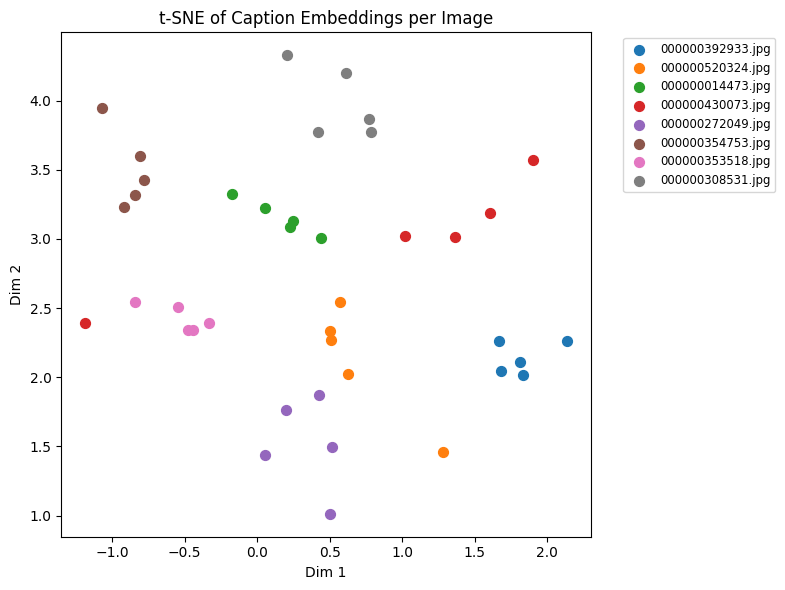

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random

def visualize_caption_embeddings(
    embedding_map_path: str,
    num_images: int = 10,
    random_seed: int = 42
):
    """
    Load precomputed caption embeddings and visualize via t-SNE.

    Args:
        embedding_map_path: path to the torch file containing {img_name: Tensor(m, D)}.
        num_images: number of images to sample for visualization.
        random_seed: for reproducibility.
    """
    # 1) Load the embedding map
    embedding_map = torch.load(embedding_map_path)

    # 2) Sample a subset of image keys
    random.seed(random_seed)
    img_keys = list(embedding_map.keys())
    sampled_keys = random.sample(img_keys, min(num_images, len(img_keys)))

    # 3) Collect embeddings and labels
    all_embs = []
    labels = []
    for idx, key in enumerate(sampled_keys):
        embs = embedding_map[key]  # Tensor of shape (m, D)
        for emb in embs:
            all_embs.append(emb.cpu().numpy())
            labels.append(idx)
    X = np.stack(all_embs)  # (num_images * m, D)

    # 4) Reduce to 2D with t-SNE
    tsne = TSNE(n_components=2, random_state=random_seed, init='pca', learning_rate='auto')
    X2 = tsne.fit_transform(X)

    # 5) Plot
    plt.figure(figsize=(8, 6))
    for idx, key in enumerate(sampled_keys):
        inds = [i for i, label in enumerate(labels) if label == idx]
        plt.scatter(X2[inds, 0], X2[inds, 1], s=50, label=key)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    plt.title('t-SNE of Caption Embeddings per Image')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_caption_embeddings("/content/gdrive/MyDrive/sonar/maps/coco2017_valcaption_embs.pt", num_images=8)

### Visualize the influence of magnitude

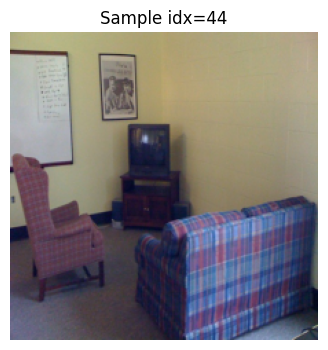

Original embedding norm: 0.2305

Scale=0.00 | Norm=0.0000 →  In the meantime, I'm going to take a look at some of the things that I've done in the past, and I'm going to show you what I've done in the past.
Scale=0.10 | Norm=0.0231 →  The only thing that's important is that you're going to be able to use it, and you're going to be able to use it.
Scale=0.20 | Norm=0.0461 →  A. The corner of the world is a place where you can see and hear God's voice, and where you can hear God's voice.
Scale=0.30 | Norm=0.0692 →  The corner of a living room and the living room of a restaurant is covered in snow and ice.
Scale=0.40 | Norm=0.0922 →  A corner of a living room with a TV in it.
Scale=0.50 | Norm=0.1152 →  A corner of a living room with a TV in it.
Scale=0.80 | Norm=0.1844 →  A corner of a living room with a TV in it.
Scale=1.00 | Norm=0.2305 →  A corner of a living room with a TV in it.
Scale=1.20 | Norm=0.2766 →  A corner of a living room with a TV in it.
Scale=1.50 | Norm=0.3457 →  A corn

In [ ]:
def visualize_image_and_norm_effect(
    val_dataset,
    vec2text_model,
    scales=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0, 6.0, 10],
    target_lang='eng_Latn',
    max_seq_len=512,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    """
    1) Randomly pick an example from val_dataset.
    2) Unnormalize and display its image.
    3) For one of its caption embeddings, vary the norm and decode back to text.
    """
    # 1) sample
    idx = random.randrange(len(val_dataset))
    img_tensor, cap_embs = val_dataset[idx]  # img_tensor normalized (3,H,W), cap_embs (m, D)

    # 2) unnormalize and plot
    # assuming normalization mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]
    mean = torch.tensor([0.5, 0.5, 0.5], device=img_tensor.device)[:, None, None]
    std  = torch.tensor([0.5, 0.5, 0.5], device=img_tensor.device)[:, None, None]
    img = img_tensor * std + mean
    img = img.clamp(0, 1).permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Sample idx={idx}")
    plt.show()

    # 3) test norm influence on one caption embedding
    emb = cap_embs[0].to(device).float()  # pick the first caption embedding
    print(f"Original embedding norm: {emb.norm().item():.4f}\n")
    for s in scales:
        scaled = (emb * s).unsqueeze(0)  # (1, D)
        # ensure float32 input to the decoder
        scaled = scaled.to(torch.float16)
        pred = vec2text_model.predict(
            scaled, target_lang=target_lang, max_seq_len=max_seq_len
        )
        text = pred[0] if isinstance(pred, list) else pred
        print(f"Scale={s:.2f} | Norm={scaled.norm().item():.4f} →  {text}")

# Example usage:
visualize_image_and_norm_effect(val_dataset, vec2text_model)

### Visualize the distribution of the norms of embeddings

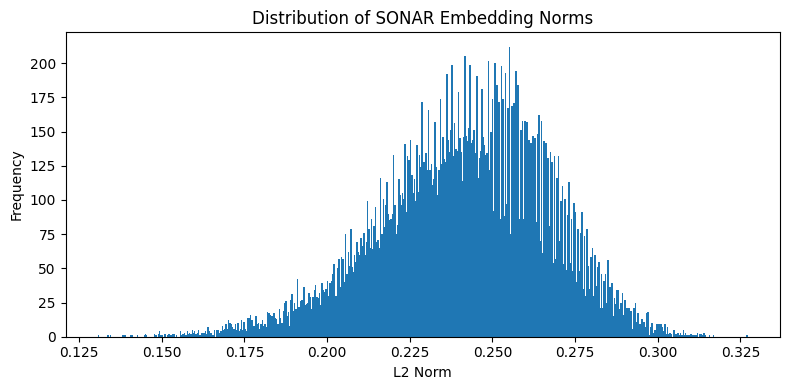

In [ ]:
def plot_norm_distribution(embedding_map_path: str, bins: int = 50):
    """
    Loads a map of image->(m,D) caption embeddings, computes L2 norms of all embeddings,
    and plots a histogram of those norms.
    """
    # 1) Load embeddings
    embedding_map = torch.load(embedding_map_path)

    # 2) Compute norms
    norms = []
    for emb_tensor in embedding_map.values():
        # emb_tensor shape (m, D)
        # compute norm per caption
        sample_norms = emb_tensor.norm(dim=1).cpu().numpy()
        norms.extend(sample_norms)

    norms = np.array(norms)

    # 3) Plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(norms, bins=bins)
    plt.title("Distribution of SONAR Embedding Norms")
    plt.xlabel("L2 Norm")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_norm_distribution("/content/gdrive/MyDrive/sonar/maps/coco2017_valcaption_embs.pt", bins=500)

## Define the model

### Define multi-positive InfoNCE loss

In [ ]:
def multi_pos_infonce_loss(img_embs, cap_embs, temperature):
    """
    img_embs: (B, D)  after F.normalize
    cap_embs: (B, m, D) after F.normalize
    """
    B, m, D = cap_embs.shape
    # flatten captions: (B*m, D)
    flat_caps = cap_embs.view(B*m, D)
    # similarity: (B, B*m)
    logits = img_embs @ flat_caps.t() / temperature

    # numerator: sum over each image's m positives
    # we know that positives for image i are indices [i*m : i*m + m]
    pos_mask = torch.zeros_like(logits, dtype=torch.bool)
    for i in range(B):
        start = i * m
        pos_mask[i, start : start + m] = True

    # exp(logits)
    exp_logits = logits.exp()
    numerator   = exp_logits.masked_select(pos_mask).view(B, m).sum(dim=1)
    denominator = exp_logits.sum(dim=1)
    loss = -torch.log(numerator / denominator).mean()
    return loss

### CosineNorm Loss

In [ ]:
class CosineNormLoss(nn.Module):
    """
    Joint L2 + cosine + norm‐matching loss.

    Args:
        alpha (float): weight for the L2 (MSE) term.
        beta  (float): weight for the cosine term.
        gamma (float): weight for the norm‐matching term.
    """
    def __init__(self, alpha: float = 1.0, beta: float = 1.0, gamma: float = 1.0):
        super().__init__()
        self.alpha = alpha
        self.beta  = beta
        self.gamma = gamma

    def forward(
        self,
        img_emb: torch.Tensor,     # (B, D)
        cap_emb: torch.Tensor      # (B, m, D) or (B, D)
    ) -> torch.Tensor:
        # If cap_emb has shape (B, m, D), collapse to mean target:
        if cap_emb.dim() == 3:
            cap_target = cap_emb.mean(dim=1)    # → (B, D)
        else:
            cap_target = cap_emb               # assumed (B, D)

        # L2 (MSE) term: preserves magnitude & direction
        l2_loss = F.mse_loss(img_emb, cap_target)

        # Cosine term: preserves direction
        cos_sim   = F.cosine_similarity(img_emb, cap_target, dim=1)  # (B,)
        cos_loss  = (1.0 - cos_sim).mean()

        # Norm‐matching term: matches lengths
        norm_pred = img_emb.norm(dim=1)        # (B,)
        norm_true = cap_target.norm(dim=1)     # (B,)
        norm_loss = F.mse_loss(norm_pred, norm_true)

        # Weighted sum
        return self.alpha * l2_loss \
             + self.beta  * cos_loss \
             + self.gamma * norm_loss

### Define the RandomMSEloss

In [ ]:
class RandomCaptionMSELoss(nn.Module):
    """
    MSE loss that samples one random caption embedding per image each forward pass.

    Args:
        reduction (str): Specifies the reduction to apply to the output:
                         'mean' | 'sum' | 'none'.
    """
    def __init__(self, reduction: str = 'mean'):
        super().__init__()
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(f"Invalid reduction: {reduction}")
        self.reduction = reduction
        # we'll compute elementwise MSE and then reduce manually
        self._mse = nn.MSELoss(reduction='none')

    def forward(self, img_embs: torch.Tensor, cap_embs: torch.Tensor) -> torch.Tensor:
        """
        Args:
            img_embs: Tensor of shape (B, D)          — image embeddings.
            cap_embs: Tensor of shape (B, m, D)      — m caption embeddings per image.

        Returns:
            Tensor: scalar if reduction in {'mean','sum'}, else shape (B,)
        """
        B, m, D = cap_embs.shape
        # 1) sample one caption index per image
        idx = torch.randint(0, m, (B,), device=img_embs.device)
        # 2) gather the sampled captions: shape (B, D)
        sampled = cap_embs[torch.arange(B, device=img_embs.device), idx]
        # 3) compute per-element squared error: (B, D)
        se = self._mse(img_embs, sampled)
        # 4) average over embedding dim → per-sample loss (B,)
        per_sample = se.mean(dim=1)

        # 5) reduce
        if self.reduction == 'mean':
            return per_sample.mean()
        elif self.reduction == 'sum':
            return per_sample.sum()
        else:  # 'none'
            return per_sample


class RandomCaptionMSELoss(nn.Module):
    """
    MSE loss between image embeddings and the single caption embedding provided by the dataset.

    Args:
        reduction (str): Specifies the reduction to apply to the output:
                         'mean' | 'sum' | 'none'.
    """
    def __init__(self, reduction: str = 'mean'):
        super().__init__()
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(f"Invalid reduction: {reduction}")
        self.reduction = reduction
        # we'll compute elementwise MSE and then reduce manually
        self._mse = nn.MSELoss(reduction='none')

    def forward(self, img_embs: torch.Tensor, cap_embs: torch.Tensor) -> torch.Tensor:
        """
        Args:
            img_embs: Tensor of shape (B, D)   — image embeddings.
            cap_embs: Tensor of shape (B, D)   — single caption embedding per image.

        Returns:
            Tensor: scalar if reduction in {'mean','sum'}, else shape (B,)
        """
        # Compute elementwise squared error: (B, D)
        se = self._mse(img_embs, cap_embs)
        # Average over embedding dimension -> per-sample loss (B,)
        per_sample = se.mean(dim=1)

        if self.reduction == 'mean':
            return per_sample.mean()
        elif self.reduction == 'sum':
            return per_sample.sum()
        else:  # 'none'
            return per_sample


### Resnet50 Encoder

In [ ]:
class ResNet50Embedder(nn.Module):
    """
    ResNet50 backbone producing fixed-size embeddings (e.g., 1024-D).

    Args:
        pretrained (bool): If True, loads ImageNet-pretrained weights.
        embedding_dim (int): Dimensionality of the output embedding.
    """
    def __init__(self, pretrained: bool = True, embedding_dim: int = 1024, weights=ResNet50_Weights.DEFAULT):
        super().__init__()
        # Load ResNet50 backbone
        if pretrained:
            # Use pretrained weights
            weights = ResNet50_Weights.DEFAULT
        base_model = resnet50(weights=weights)
        # Save the feature dimensionality for projection
        in_features = base_model.fc.in_features
        # Replace the final fully connected layer with a new one
        base_model.fc = nn.Linear(in_features, embedding_dim)
        # Initialize the new layer
        nn.init.xavier_uniform_(base_model.fc.weight)
        self.backbone = base_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: image -> embedding

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W).

        Returns:
            torch.Tensor: Embedding of shape (batch_size, embedding_dim).
        """
        embeddings = self.backbone(x)   # shape: (batch_size, embedding_dim)
        return embeddings

    def load_weights(self, path: str):
        """
        Load weights from a file.

        Args:
            path (str): Path to the weights file.
        """
        state_dict = torch.load(path, weights_only=True)
        self.backbone.load_state_dict(state_dict)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Example: produce 1024-D embeddings
encoder = ResNet50Embedder(pretrained=True, embedding_dim=1024).to(device)
summary(encoder, (3, 224, 224), device=device.type)
dummy_input = torch.randn(10, 3, 224, 224, device=device)
embed = encoder(dummy_input)
print(f"Output embedding shape: {embed.shape}")


### ViT Embedder

In [ ]:

class ViTEmbedder(nn.Module):
    """
    Vision Transformer–based embedder mapping images to SONAR-space embeddings.

    Backbone: ViT-B/16
    - Pools across all patch tokens via self‐attention
    - Projects via a 2-layer MLP head (expand→contract)
    """
    def __init__(
        self,
        embedding_dim: int = 1024,
        hidden_dim:    int = 3072,
        num_heads:     int = 8,
        dropout:       float = 0.1,
        pretrained:    bool  = True
    ):
        super().__init__()
        # 1) Load ViT-B/16
        weights = ViT_B_16_Weights.DEFAULT if pretrained else None
        self.vit = vit_b_16(weights=weights)
        # hidden size of the transformer tokens (typically 768 for ViT-B)
        vit_dim = self.vit.hidden_dim

        # 2) Attention‐based pooling over all tokens
        self.pooler = nn.MultiheadAttention(
            embed_dim=vit_dim,
            num_heads=num_heads,
            batch_first=True
        )

        # 3) Two‐layer MLP head (expands then contracts)
        self.head = nn.Sequential(
            nn.LayerNorm(vit_dim),
            nn.Dropout(dropout),
            nn.Linear(vit_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embedding_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, 3, 224, 224) input images
        returns: (B, embedding_dim) SONAR-style embeddings
        """
        # 1) Extract all token embeddings from ViT
        #    Using private API vit._process_input + vit.encoder
        tokens = self.vit._process_input(x)                    # (B, 1+N, vit_dim)
        tokens = self.vit.encoder.dropout(tokens)
        tokens = self.vit.encoder.layers(tokens)               # (B, 1+N, vit_dim)

        # 2) Pool down to a single vector
        pooled, _ = self.pooler(tokens, tokens, tokens)        # (B, 1+N, vit_dim)
        cls_vec = pooled.mean(dim=1)                           # (B, vit_dim)

        # 3) Run through MLP head into SONAR space
        return self.head(cls_vec)                              # (B, embedding_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = ViTEmbedder().to(device)
dummy  = torch.randn(2, 3, 224, 224, device=device)
out    = model(dummy)  # => torch.Size([2, 1024])

In [ ]:
gc.collect()

33926

### ViT Large Embedder

In [ ]:
from torchvision.models import vit_l_16, ViT_L_16_Weights

class ViTLargeEmbedder(nn.Module):
    def __init__(
        self,
        embedding_dim: int = 1024,
        hidden_dim:    int = 4096,
        num_heads:    int = 16,
        dropout:      float = 0.1,
        pretrained:   bool  = True
    ):
        super().__init__()
        weights = ViT_L_16_Weights.DEFAULT if pretrained else None
        self.vit = vit_l_16(weights=weights)

        # instead of self.vit.heads.in_features, just use:
        vit_dim = self.vit.hidden_dim    # == 1024 for ViT-L/16

        # attention‐pooler
        self.pooler = nn.MultiheadAttention(
            embed_dim=vit_dim,
            num_heads=num_heads,
            batch_first=True
        )

        # richer MLP head
        self.head = nn.Sequential(
            nn.LayerNorm(vit_dim),
            nn.Dropout(dropout),
            nn.Linear(vit_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embedding_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # get all token embeddings
        tokens = self.vit._process_input(x)                     # (B, #tokens, vit_dim)
        tokens = self.vit.encoder.layers(self.vit.encoder.dropout(tokens))
        # pool + head
        pooled, _ = self.pooler(tokens, tokens, tokens)         # (B, #tokens, vit_dim)
        cls_vec = pooled.mean(dim=1)                            # (B, vit_dim)
        return self.head(cls_vec) / 4                           # (B, embedding_dim)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = ViTLargeEmbedder().to(device)
dummy  = torch.randn(2, 3, 224, 224, device=device)
out    = model(dummy)  # => torch.Size([2, 1024])

Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [00:06<00:00, 201MB/s]


### Model I/O

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(path, model, optimizer= None, scheduler= None, metric='val_loss'):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    print("\nResuming training from epoch:", epoch)
    print('----------------------------------------\n')
    # print("Epochs left: ", config['epochs'] - epoch)
    print("Optimizer: \n", optimizer)
    # print("Current Schedueler T_cur:", scheduler.T_cur)

    print("Best Val Loss:", metric)

    return [model, optimizer, scheduler, epoch, metric]

### Train function

In [ ]:
def train_epoch(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    scaler: torch.cuda.amp.GradScaler,
    criterion: nn.Module,
    device: torch.device
) -> float:
    """
    Train the model for one epoch.
    Returns the average training loss.
    """
    model.train()
    running_loss = 0.0
    total_samples = 0

    pbar = tqdm(train_loader, desc="Training", unit="batch")
    for images, cap_embs in pbar:
        images   = images.to(device)
        cap_embs = cap_embs.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            img_embs = model(images)           # (B, D)
            loss     = criterion(img_embs, cap_embs)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        pbar.set_postfix(train_loss=f"{loss.item():.12f}")

    avg_loss = running_loss / total_samples
    return avg_loss

In [ ]:
from sonar.models.blaser.loader import load_blaser_model

# Pre‐load once:
blaser_qe     = load_blaser_model("blaser_2_0_qe").eval().to(device)
text_embedder = TextToEmbeddingModelPipeline(
    encoder="text_sonar_basic_encoder",
    tokenizer="text_sonar_basic_encoder",
    device=device,  # make sure the pipeline uses your GPU
    dtype=torch.float16
)

In [ ]:
img, true_embs = val_dataset[0]
ref_emb = true_embs[0]
student_emb = model(img.unsqueeze(0).to(device))
student_emb = student_emb.to(torch.float16)
blaser_qe(src=ref_emb.unsqueeze(0).to(torch.float32).to(device), mt=student_emb).item()

2.3701741695404053

In [ ]:
@torch.no_grad()
def val_epoch(
    model: nn.Module,
    val_loader: torch.utils.data.DataLoader,
    val_criterion: nn.Module,
    device: torch.device,
    vec2text_model,           # decoder with .predict(tensor, target_lang, max_seq_len)
    target_lang: str = 'eng_Latn',
    max_seq_len: int = 512
) -> float:
    """
    1) Average validation loss over val_loader (img_embs vs. cap_embs).
    2) Sample one random image from val_dataset, decode its predicted embedding,
       and print true vs. predicted captions.
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    val_dataset = val_loader.dataset

    # 1) compute avg loss
    pbar = tqdm(val_loader, desc="Validation", unit="batch")
    for images, cap_embs in pbar:
        images, cap_embs = images.to(device), cap_embs.to(device)
        img_embs = model(images)                       # (B, D)
        loss = val_criterion(img_embs, cap_embs).item()
        batch_size = images.size(0)
        total_loss += loss * batch_size
        total_samples += batch_size
        pbar.set_postfix(val_loss=f"{loss:.12f}")
    avg_loss = total_loss / total_samples

    # 2) sample one random example for human‐readable check
    idx = random.randrange(len(val_dataset))
    img, true_embs = val_dataset[idx]               # img: (3,H,W), true_captions: List[str]

    # get student (predicted) embedding
    with torch.no_grad():
        student_emb = model(img.unsqueeze(0).to(device))  # (1, D)
        student_emb = student_emb.to(torch.float16)       # ensure full precision

    # decode to text
    pred_cap_list     = vec2text_model.predict(
        student_emb,
        target_lang=target_lang,
        max_seq_len=max_seq_len
    )
    pred_caption  = pred_cap_list[0] if isinstance(pred_cap_list, list) else pred_cap_list

    # get teacher embedding for the first true caption
    # (you may batch this if you like, but here it’s just one)
    true_cap_list = vec2text_model.predict(
        true_embs,
        target_lang=target_lang,
        max_seq_len=max_seq_len
    )

    cos_sim      = F.cosine_similarity(student_emb.to(device), true_embs[0].to(device), dim=1).item()
    # clamp for numerical stability
    cos_sim_clamped = max(min(cos_sim, 1-1e-6), -1+1e-6)
    angle_rad    = math.acos(cos_sim_clamped)
    angle_deg    = angle_rad * 180.0 / math.pi


    # 2e) Compute BLASER_QE scores for each reference → prediction
    scores = []
    for i, ref_emb in enumerate(true_embs):
        # BLASER_QE expects src=ref, mt=mt
        score = blaser_qe(src=ref_emb.unsqueeze(0).to(torch.float32).to(device), mt=student_emb).item()
        scores.append(score)

    best_i     = int(torch.tensor(scores).argmax())
    best_score = scores[best_i]
    best_ref   = true_cap_list[best_i]


    # 3) print comparison
    print(f"\nSample #{idx} True caption: {true_cap_list[0]}")
    print(f" → Teacher embedding norm: {true_embs[0].norm().item():.4f}")
    print(f"Predicted  caption: {pred_caption}")
    print(f" → Student embedding norm: {student_emb.norm().item():.4f}\n")
    print(f" Cosine sim:       {cos_sim:.4f}")
    print(f" Angle:            {angle_rad:.4f} rad ({angle_deg:.1f}°)")
    print(f" → BLASER_QE best score: {best_score:.4f}   (ref “{best_ref}”)")

    model.train()
    return avg_loss

In [ ]:
def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    scaler: torch.amp.GradScaler,
    criterion: nn.Module,
    val_criterion: nn.Module,
    device: torch.device,
    num_epochs: int,
    last_path: str = "last_epoch.pth",
    best_path: str = "best_model.pth"
):
    """
    Train for num_epochs, saving:
      - last_epoch.pth after every epoch
      - best_model.pth whenever val_loss improves
    """
    best_val = float("inf")

    # Optionally resume
    # model, optimizer, scheduler, start_epoch, best_val = load_model(...)

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        # 1) Train
        train_loss = train_epoch(
            model, train_loader, optimizer, scaler, criterion, device
        )
        print(f"  -> Train Loss: {train_loss:.12f}")

        # 2) Validate
        val_loss = val_epoch(
            model, val_loader, val_criterion, device, vec2text_model, target_lang='eng_Latn', max_seq_len=512
        )
        print(f"  -> Val   Loss: {val_loss:.12f}")

        scheduler.step(val_loss)

        # 3) Save last‐epoch checkpoint
        save_model(
            model, optimizer, scheduler,
            metric=("val_loss", val_loss),
            epoch=epoch,
            path=last_path
        )
        print(f"  Saved last epoch to {last_path}")

        # 4) Save best checkpoint
        if val_loss < best_val and epoch % 5 == 0:
            best_val = val_loss
            save_model(
                model, optimizer, scheduler,
                metric=("val_loss", val_loss),
                epoch=epoch,
                path=best_path
            )
            print(f"  New best! Saved model to {best_path}")

    print("\nTraining complete.")
    return model


In [ ]:
# del model
gc.collect()

259471

In [ ]:
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model        = ViTEmbedder(embedding_dim=1024).to(device)
model  = ViTLargeEmbedder().to(device)
optimizer    = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-2)
scaler       = torch.amp.GradScaler()
scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=0.0000001)
# criterion    = RandomCaptionMSELoss(reduction="mean")
# val_criterion= RandomCaptionMSELoss(reduction="mean")
criterion    = CosineNormLoss(alpha=1.0, beta=10, gamma=100)
val_criterion= CosineNormLoss(alpha=1.0, beta=10, gamma=100)

In [ ]:
model, _, _, _, val_loss = load_model("./best_model.pth", model, metric='val_loss')

In [ ]:
# train_loader and val_loader assumed defined elsewhere
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    scaler,
    criterion,
    val_criterion,
    device,
    num_epochs=20
)

In [112]:
!cp best_model.pth /content/gdrive/MyDrive/sonar/
!cp last_epoch.pth /content/gdrive/MyDrive/sonar/

In [113]:
gc.collect()

6267

In [114]:
model, _, _, _, val_loss = load_model("./last_epoch.pth", model, metric='val_loss')


Resuming training from epoch: 20
----------------------------------------

Optimizer: 
 None
Best Val Loss: 1.984091823387146


In [115]:
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model        = ViTEmbedder(embedding_dim=1024).to(device)
model  = ViTLargeEmbedder().to(device)
optimizer    = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-2)
scaler       = torch.amp.GradScaler()
scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=0.0000001)
# criterion    = RandomCaptionMSELoss(reduction="mean")
# val_criterion= RandomCaptionMSELoss(reduction="mean")
criterion    = CosineNormLoss(alpha=100, beta=10, gamma=10)
val_criterion= CosineNormLoss(alpha=100, beta=10, gamma=10)

In [ ]:
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    scaler,
    criterion,
    val_criterion,
    device,
    num_epochs=50
)

In [117]:
model, _, _, _, val_loss = load_model("./best_model.pth", model, metric='val_loss')


Resuming training from epoch: 35
----------------------------------------

Optimizer: 
 None
Best Val Loss: 1.9036434883117677


In [132]:
img, true_embs = val_dataset[0]
pred_emb = model(img.unsqueeze(0).to(device))

true_caps = vec2text_model.predict(true_embs, target_lang='eng_Latn', max_seq_len=512)
for true_cap in true_caps:
    print(true_cap)
pred_cap = vec2text_model.predict(pred_emb.to(torch.float16), target_lang='eng_Latn', max_seq_len=512)
print(pred_cap)


A living area with a television and a table
A person standing at a table in a room.
A room with chairs, a table, and a woman in it.
A woman standing in a kitchen by a window
A woman stands in the dining area at the table.
['A bedroom with a desk and a kitchen table.']


In [136]:
# !pip install evaluate
!pip install pycocoevalcap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 140.9 MB/s eta 0:00:00


In [165]:
class COCOTxtCaptionDataset(Dataset):
    """
    Returns (image_tensor, list_of_captions) for each idx.
    """
    def __init__(
        self,
        img_dir: str,
        coco_json: str,
        transform: T.Compose = None,
        num_caps: int = 5,
        subset: float = 1.0,
    ):
        self.img_dir = Path(img_dir)
        self.transform = transform or T.Compose([
            T.Resize((224,224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406],
                        std=[0.229,0.224,0.225]),
        ])

        # load COCO annotations
        with open(coco_json) as f:
            coco = json.load(f)

        # group captions by image_id
        caps = defaultdict(list)
        for ann in coco["annotations"]:
            img_name = f"{ann['image_id']:012d}.jpg"
            caps[img_name].append(ann["caption"])

        # keep only up to num_caps per image
        for img_name, clist in caps.items():
            caps[img_name] = sorted(clist)[:num_caps]

        # sort and optionally subsample
        self.ids = sorted(caps.keys())
        if subset < 1.0:
            k = max(1, int(len(self.ids) * subset))
            self.ids = self.ids[:k]

        self.caps = caps  # mapping img_name -> list[str]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_name = self.ids[idx]
        # load & transform image
        img = Image.open(self.img_dir / img_name).convert("RGB")
        img = self.transform(img)
        # fetch list of raw text captions
        caption_list = self.caps[img_name]
        return img, caption_list


def collate_text_caps(batch):
    """
    batch: list of (img_tensor, [cap1, cap2, ...])
    returns:
       imgs: Tensor (B,3,H,W)
       caps: List[List[str]] length B
    """
    imgs = torch.stack([item[0] for item in batch], dim=0)
    caps = [item[1] for item in batch]
    return imgs, caps


# usage:

val_txtdataset = COCOTxtCaptionDataset(
    img_dir="./images/val2017",
    coco_json="./annotations/annotations/captions_val2017.json",
    transform=T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406],
                    std=[0.229,0.224,0.225]),
    ]),
    num_caps=5,
    subset=1.0,
)

val_txtloader = DataLoader(
    val_txtdataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_text_caps,
)

In [ ]:
import torch
from torch.utils.data import DataLoader
import evaluate

# Try loading the HF cider metric; if absent, fall back to pycocoevalcap
try:
    cider_metric = evaluate.load("cider")
    def compute_cider(preds, refs):
        return cider_metric.compute(predictions=preds, references=refs)["cider"]
except FileNotFoundError:
    from pycocoevalcap.cider.cider import Cider
    cider_scorer = Cider()
    def compute_cider(preds, refs):
        # preds: List[str], refs: List[List[str]]
        gts = {str(i): refs[i] for i in range(len(refs))}
        res = {str(i): [preds[i]] for i in range(len(preds))}
        score, _ = cider_scorer.compute_score(gts, res)
        return score

# 1) Wrap your val_dataset in a DataLoader
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# 2) Load BLEU
bleu = evaluate.load("bleu")

model.eval()
predictions, references = [], []

# 3) Iterate over validation set
for imgs, true_caps in tqdm(val_txtloader):
    imgs = imgs.to(device)        # (B,3,H,W)
    # true_embs = true_embs[0]    # list of SONAR embeddings for this image

    # a) Decode all true embeddings into text references
    # true_caps = vec2text_model.predict(
    #     true_embs,
    #     target_lang="eng_Latn",
    #     max_seq_len=512
    # )

    # b) Get your model’s predicted embedding
    with torch.no_grad():
        pred_embs = model(imgs)                  # (1, D)
    pred_embs = pred_embs.to(torch.float16)

    # c) Decode that to text
    pred_caps = vec2text_model.predict(
        pred_embs,
        target_lang="eng_Latn",
        max_seq_len=512
    )

    predictions.extend(pred_caps)
    references.extend(true_caps)

# 4) Compute BLEU-4 and CIDEr
bleu4 = bleu.compute(predictions=predictions, references=references)["bleu"] * 100
cider = compute_cider(predictions, references)

print(f"Model + vec2text → BLEU-4: {bleu4:.2f}, CIDEr: {cider:.2f}")


In [118]:
!cp best_model.pth /content/gdrive/MyDrive/sonar/ViT/
!cp last_epoch.pth /content/gdrive/MyDrive/sonar/ViT/

In [ ]:
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    scaler,
    criterion,
    val_criterion,
    device,
    num_epochs=10
)


Epoch 1/10


Training: 100%|██████████| 37/37 [00:20<00:00,  1.79batch/s, train_loss=0.392541766167]


  -> Train Loss: 0.399699776104


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.93batch/s, val_loss=0.380350947380]



Sample #183 True captions:
True caption: ['A man doing a trick on roller-skates in a skate park.']
with L2 norm 0.265380859375
Predicted caption: A boat on a beach.
with L2 norm 0.28125

  -> Val   Loss: 0.403055090904
  Saved last epoch to last_epoch.pth
  New best! Saved model to best_model.pth

Epoch 2/10


Training: 100%|██████████| 37/37 [00:20<00:00,  1.80batch/s, train_loss=0.387802809477]


  -> Train Loss: 0.393867102623


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.95batch/s, val_loss=0.374704003334]



Sample #433 True captions:
True caption: ['A brown horse stands over a light colored dog.']
with L2 norm 0.2476806640625
Predicted caption: A doggy on a table.
with L2 norm 0.276611328125

  -> Val   Loss: 0.396864857674
  Saved last epoch to last_epoch.pth
  New best! Saved model to best_model.pth

Epoch 3/10


Training: 100%|██████████| 37/37 [00:20<00:00,  1.81batch/s, train_loss=0.387077867985]


  -> Train Loss: 0.390829987433


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.91batch/s, val_loss=0.372964054346]



Sample #176 True captions:
True caption: ['A person at a table in a room with some food.']
with L2 norm 0.23681640625
Predicted caption: A bushel sitting on a lawn
with L2 norm 0.28173828125

  -> Val   Loss: 0.393315111399
  Saved last epoch to last_epoch.pth
  New best! Saved model to best_model.pth

Epoch 4/10


Training: 100%|██████████| 37/37 [00:20<00:00,  1.80batch/s, train_loss=0.383510142565]


  -> Train Loss: 0.388163730326


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.92batch/s, val_loss=0.370290875435]



Sample #309 True captions:
True caption: ['A man holding a tennis racquet standing on a court.']
with L2 norm 0.27197265625
Predicted caption: A doggy sitting on a table.
with L2 norm 0.26416015625

  -> Val   Loss: 0.389901806831
  Saved last epoch to last_epoch.pth
  New best! Saved model to best_model.pth

Epoch 5/10


Training: 100%|██████████| 37/37 [00:20<00:00,  1.81batch/s, train_loss=0.380478948355]


  -> Train Loss: 0.384445802663


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.94batch/s, val_loss=0.369252294302]



Sample #135 True captions:
True caption: ['A brightly decorated living room with a stylish feel.']
with L2 norm 0.192138671875
Predicted caption: A bushel sitting on a lawn.
with L2 norm 0.272705078125

  -> Val   Loss: 0.388055759192
  Saved last epoch to last_epoch.pth
  New best! Saved model to best_model.pth

Epoch 6/10


Training: 100%|██████████| 37/37 [00:20<00:00,  1.81batch/s, train_loss=0.377935916185]


  -> Train Loss: 0.382445734719


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.89batch/s, val_loss=0.366979509592]



Sample #413 True captions:
True caption: ['A man standing alongside of a truck trailer.']
with L2 norm 0.248779296875
Predicted caption: A doggy sitting on a lawn.
with L2 norm 0.26025390625

  -> Val   Loss: 0.385344976664
  Saved last epoch to last_epoch.pth
  New best! Saved model to best_model.pth

Epoch 7/10


Training: 100%|██████████| 37/37 [00:20<00:00,  1.80batch/s, train_loss=0.374147057533]


  -> Train Loss: 0.380319185265


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.94batch/s, val_loss=0.366962403059]



Sample #22 True captions:
True caption: ['A city bus drives through a city area.']
with L2 norm 0.2325439453125
Predicted caption: A bike sitting on a lawn.
with L2 norm 0.27685546875

  -> Val   Loss: 0.384382870436
  Saved last epoch to last_epoch.pth
  New best! Saved model to best_model.pth

Epoch 8/10


Training: 100%|██████████| 37/37 [00:20<00:00,  1.81batch/s, train_loss=0.371506065130]


  -> Train Loss: 0.379303506435


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.85batch/s, val_loss=0.368240207434]



Sample #373 True captions:
True caption: ['A bedroom with a large bed facing a fireplace that has a television on top of it, in a shelf space.']
with L2 norm 0.2734375
Predicted caption: A bike sitting on a table.
with L2 norm 0.260498046875

  -> Val   Loss: 0.384657029867
  Saved last epoch to last_epoch.pth

Epoch 9/10


Training: 100%|██████████| 37/37 [00:20<00:00,  1.81batch/s, train_loss=0.374012589455]


  -> Train Loss: 0.378337858292


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.94batch/s, val_loss=0.368587732315]



Sample #235 True captions:
True caption: ['A cheese pizza cut into eight pieces in the box.']
with L2 norm 0.257080078125
Predicted caption: A blanket sitting on a lawn.
with L2 norm 0.259765625

  -> Val   Loss: 0.384331647873
  Saved last epoch to last_epoch.pth
  New best! Saved model to best_model.pth

Epoch 10/10


Training: 100%|██████████| 37/37 [00:20<00:00,  1.81batch/s, train_loss=0.374738007784]


  -> Train Loss: 0.377034157010


Validation: 100%|██████████| 16/16 [00:05<00:00,  2.90batch/s, val_loss=0.365112543106]



Sample #274 True captions:
True caption: ['A comfortable hotel room featuring a large screen television.']
with L2 norm 0.2294921875
Predicted caption: A bushel sitting on a window.
with L2 norm 0.259765625

  -> Val   Loss: 0.381146434784
  Saved last epoch to last_epoch.pth
  New best! Saved model to best_model.pth

Training complete.


#### Validate encoder based on average MSE loss

In [ ]:
# --- Validation function ---
@torch.no_grad()
def validate_mse(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device
) -> float:
    """
    Runs one epoch of validation, returning the average MSE between
    each image embedding and all of its m caption embeddings.

    For each batch (B, m, D):
      - img_embs:   (B, D)
      - cap_embs:   (B, m, D)
    We expand img_embs → (B, m, D) and do MSE over all elements.
    """
    model.eval()
    mse_fn = nn.MSELoss(reduction='mean')
    total_loss = 0.0
    n_batches  = 0

    pbar = tqdm(loader, desc="Validation (MSE)")
    for images, cap_embs in pbar:
        images, cap_embs = images.to(device), cap_embs.to(device)
        # 1) get image embeddings
        img_embs = model(images)            # (B, D)

        # 2) expand to match caption dims
        B, m, D = cap_embs.shape
        img_exp = img_embs.unsqueeze(1)     # (B, 1, D)
        img_exp = img_exp.expand(-1, m, -1) # (B, m, D)

        # 3) compute MSE
        loss = mse_fn(img_exp, cap_embs)    # scalar mean over B*m*D

        total_loss += loss.item()
        n_batches  += 1
        pbar.set_postfix(curr_mse=f"{loss.item():.10f}")

    pbar.close()
    model.train()
    return total_loss / n_batches


@torch.no_grad()
def validate_mse_single(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device
) -> float:
    """
    Runs one epoch of validation, returning the average MSE between
    each image embedding and its single associated caption embedding.

    For each batch (B, D):
      - img_embs:   (B, D)
      - cap_embs:   (B, D)
    """
    model.eval()
    mse_fn = nn.MSELoss(reduction='mean')
    total_loss = 0.0
    n_batches  = 0

    pbar = tqdm(loader, desc="Validation (MSE)")
    for images, cap_embs in pbar:
        images, cap_embs = images.to(device), cap_embs.to(device)
        # 1) get image embeddings
        img_embs = model(images)            # (B, D)

        # 2) compute MSE against the single caption embedding
        loss = mse_fn(img_embs, cap_embs)   # scalar mean over B*D

        total_loss += loss.item()
        n_batches  += 1
        pbar.set_postfix(curr_mse=f"{loss.item():.10f}")

    pbar.close()
    model.train()
    return total_loss / n_batches

In [ ]:
from sonar.inference_pipelines.speech import SpeechToEmbeddingModelPipeline
s2vec_model = SpeechToEmbeddingModelPipeline(encoder="sonar_speech_encoder_eng")

### Training loop

In [ ]:
# Hyperparameters
lr = 1e-3
weight_decay = 1e-2
temperature = 0.07
num_epochs = 5

# Setup
train_criterion = RandomCaptionMSELoss(reduction='sum')
optimizer = torch.optim.AdamW(encoder.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = torch.amp.GradScaler()

best_val_loss = float("inf")
encoder, _, _, epoch, best_val_loss = load_model(path=f"/content/gdrive/MyDrive/sonar/last_epoch.pth", model=encoder, optimizer= None, scheduler= None, metric="val_loss")

for epoch in range(epoch, num_epochs + 1):
    # Train
    training_MSE_loss = train_epoch(encoder, train_loader, optimizer, scaler, criterion=train_criterion, \
                                             device='cuda', epoch=epoch, num_epochs=num_epochs)
    val_loss = validate_mse_single(encoder, val_loader, device)
    scheduler.step(val_loss)
    print(f"Epoch {epoch} Training MSE Loss {training_MSE_loss:.10f}")
    print(f"Epoch {epoch} Validation MSE Loss: {val_loss:.10f}")
    save_model(encoder, optimizer, scheduler, ["val_loss", val_loss], epoch, path=f"/content/gdrive/MyDrive/sonar/last_epoch.pth")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_model(encoder, optimizer, scheduler, ["val_loss", val_loss], epoch, path=f"/content/gdrive/MyDrive/sonar/best_encoder.pth")

In [ ]:
validate_mse_single(encoder, val_loader, device)

Validation (MSE): 100%|██████████| 16/16 [00:04<00:00,  3.25it/s, curr_mse=0.0000445471]


4.187526405985409e-05

In [ ]:
import gc
gc.collect()

6073

In [ ]:
encoder, _, _, epoch, best_val_loss = load_model(path=f"/content/gdrive/MyDrive/sonar/last_epoch.pth", model=encoder, optimizer= None, scheduler= None, metric="val_loss")


Resuming training from epoch: 1
----------------------------------------

Optimizer: 
 None
Best Val Loss: 0.49897893712778757


### Validate the encoder

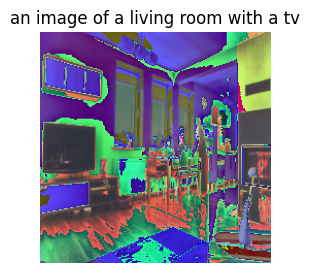

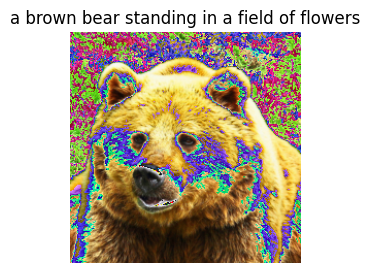

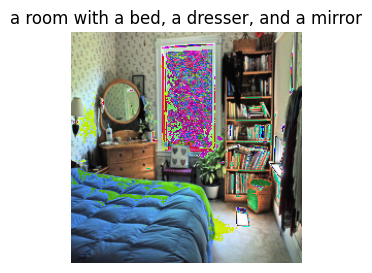

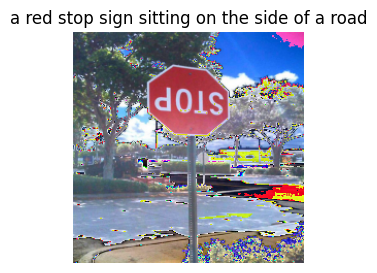

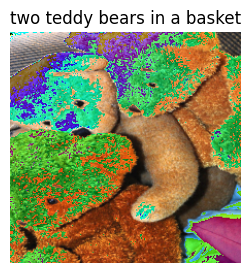

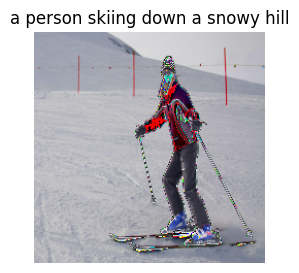

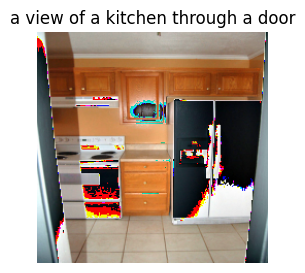

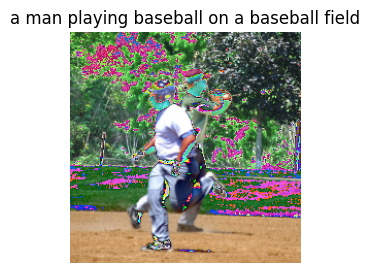

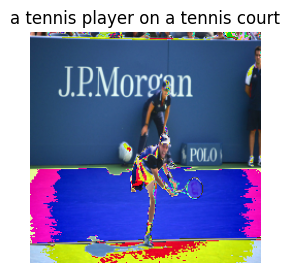

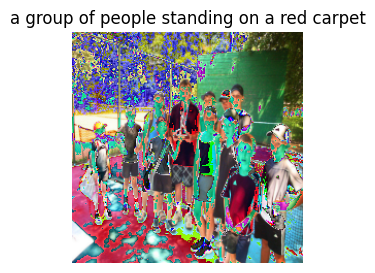

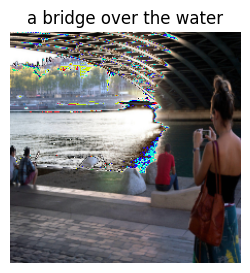

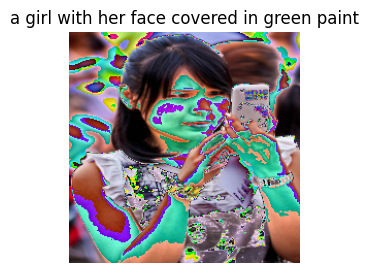

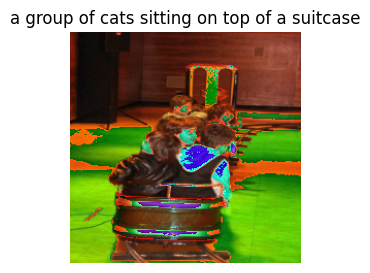

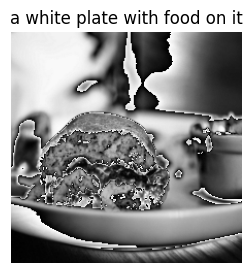

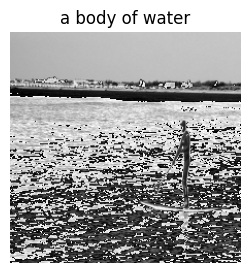

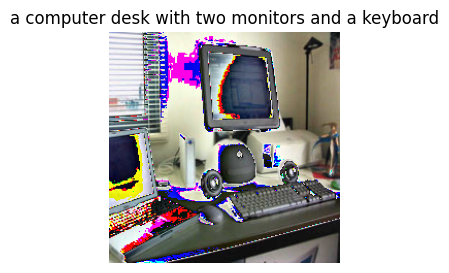

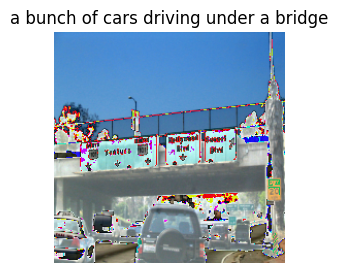

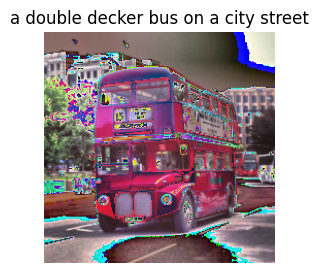

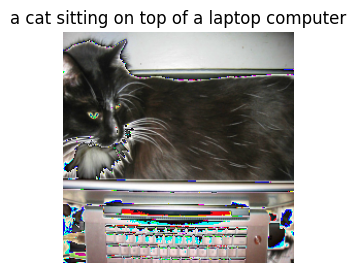

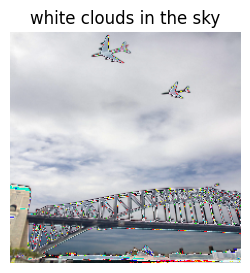

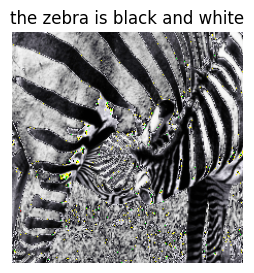

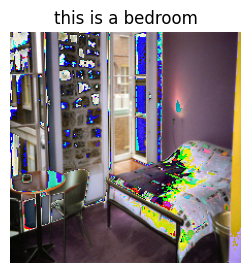

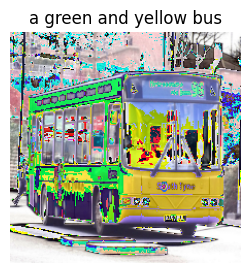

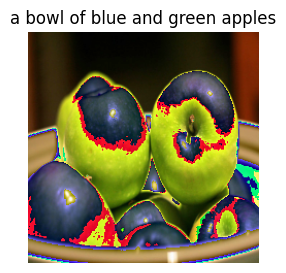

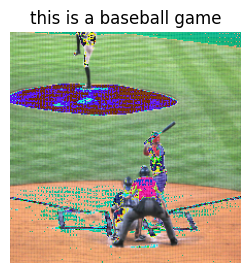

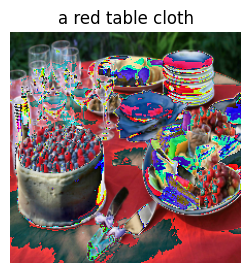

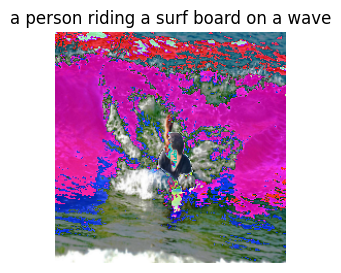

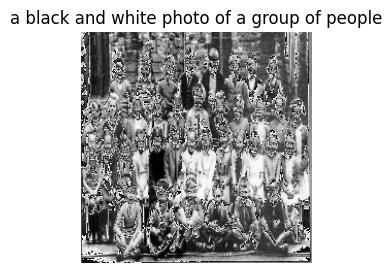

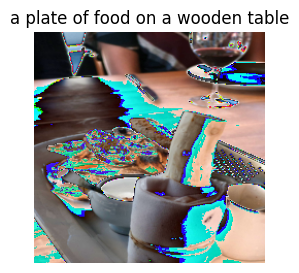

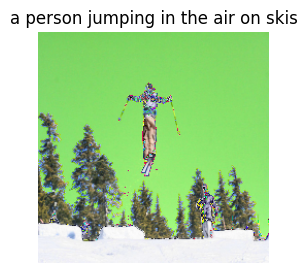

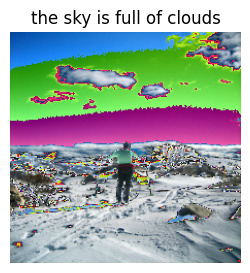

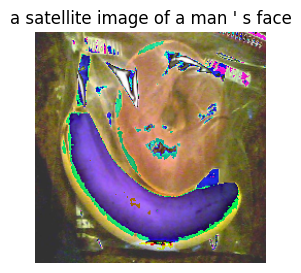

Batch 1 captions: ['an image of a living room with a tv', 'a brown bear standing in a field of flowers', 'a room with a bed, a dresser, and a mirror', 'a red stop sign sitting on the side of a road', 'two teddy bears in a basket', 'a person skiing down a snowy hill', 'a view of a kitchen through a door', 'a man playing baseball on a baseball field', 'a tennis player on a tennis court', 'a group of people standing on a red carpet', 'a bridge over the water', 'a girl with her face covered in green paint', 'a group of cats sitting on top of a suitcase', 'a white plate with food on it', 'a body of water', 'a computer desk with two monitors and a keyboard', 'a bunch of cars driving under a bridge', 'a double decker bus on a city street', 'a cat sitting on top of a laptop computer', 'white clouds in the sky', 'the zebra is black and white', 'this is a bedroom', 'a green and yellow bus', 'a bowl of blue and green apples', 'this is a baseball game', 'a red table cloth', 'a person riding a surf

In [ ]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# 1) Load BLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model     = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model.to(device).eval()

# 2) Iterate over your val_loader
def run_blip_captioning(val_loader, num_batches=5):
    """
    Runs BLIP image-captioning on a few batches from val_loader.
    """
    for i, (images, _) in enumerate(val_loader):
        if i >= num_batches:
            break

        # images: Tensor[B,3,H,W], normalized already
        # Convert back to PIL or float tensors in [0,1]
        pil_images = [to_pil_image(img.cpu()) for img in images]

        # 3) Preprocess for BLIP
        inputs = processor(images=pil_images, return_tensors="pt").to(device)

        # 4) Generate captions
        out_ids = model.generate(
            **inputs,
            max_length=30,
            num_beams=5,
            early_stopping=True
        )
        captions = processor.batch_decode(out_ids, skip_special_tokens=True)

        # 5) Display & print
        for img, cap in zip(pil_images, captions):
            plt.figure(figsize=(3,3))
            plt.imshow(img)
            plt.axis("off")
            plt.title(cap)
            plt.show()

        print(f"Batch {i+1} captions:", captions)
        print("-" * 80)

# Usage
run_blip_captioning(val_loader, num_batches=1)

In [ ]:
from torchinfo import summary
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

# load BLIP
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model     = BlipForConditionalGeneration.from_pretrained(
                "Salesforce/blip-image-captioning-base"
            ).to(device)
model.eval()

# prepare dummy inputs
dummy_image = torch.randn(1, 3, 224, 224, device=device)
dummy_ids   = processor.tokenizer(
                  ["a sample caption"],
                  return_tensors="pt",
                  padding="max_length",
                  max_length=16
              ).input_ids.to(device)

# now summary with input_data
summary(
    model,
    input_data = {
      "pixel_values": dummy_image,
      "input_ids":    dummy_ids
    },
    col_names   = ["input_size","output_size","num_params","trainable"],
    depth       = 3,
)


Layer (type:depth-idx)                                            Input Shape               Output Shape              Param #                   Trainable
BlipForConditionalGeneration                                      --                        [1, 197, 768]             --                        True
├─BlipVisionModel: 1-1                                            --                        [1, 768]                  --                        True
│    └─BlipVisionEmbeddings: 2-1                                  [1, 3, 224, 224]          [1, 197, 768]             443,904                   True
│    │    └─Conv2d: 3-1                                           [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
│    └─BlipEncoder: 2-2                                           --                        [1, 197, 768]             --                        True
│    │    └─ModuleList: 3-2                                       --                        --       

In [ ]:
from torchvision.transforms.functional import to_pil_image


def compare_within_between_caption_mse(val_loader, device, num_samples=5):
    """
    Samples pairs of images from val_loader and computes:
      - Within-image pairwise MSE among the m captions
      - Between-image pairwise MSE between captions of two different images
    Displays the two images side-by-side and prints both MSE matrices + averages.
    """
    val_iter = iter(val_loader)
    for i in range(num_samples):
        # Fetch next batch (wrap around if needed)
        try:
            images, caps_embs = next(val_iter)
        except StopIteration:
            val_iter = iter(val_loader)
            images, caps_embs = next(val_iter)

        # Take first two samples in the batch
        img1, img2 = images[0], images[1]           # (3, H, W)
        emb1, emb2 = caps_embs[0].to(device), caps_embs[1].to(device)  # (m, D), (m, D)

        # Display images side by side
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(to_pil_image(img1.cpu()))
        axes[0].set_title("Image A"); axes[0].axis("off")
        axes[1].imshow(to_pil_image(img2.cpu()))
        axes[1].set_title("Image B"); axes[1].axis("off")
        plt.show()

        # Within-image MSE matrix (m x m)
        m, D = emb1.shape
        diffs_within = emb1.unsqueeze(1) - emb1.unsqueeze(0)   # (m, m, D)
        mse_within = diffs_within.pow(2).mean(dim=2)           # (m, m)
        # mask diagonal and compute average off-diagonal
        mask = ~torch.eye(m, dtype=torch.bool, device=device)
        avg_within = mse_within[mask].mean().item()

        print(f"[Sample {i+1}] Within-image MSE avg: {avg_within:.4f}")
        print("Within-image MSE matrix:\n", mse_within.cpu().numpy())

        # Between-image MSE matrix (m x m)
        diffs_between = emb1.unsqueeze(1) - emb2.unsqueeze(0)  # (m, m, D)
        mse_between = diffs_between.pow(2).mean(dim=2)         # (m, m)
        avg_between = mse_between.mean().item()                # include all entries

        print(f"[Sample {i+1}] Between-image MSE avg: {avg_between:.4f}")
        print("Between-image MSE matrix:\n", mse_between.cpu().numpy(), "\n\n")

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
compare_within_between_caption_mse(val_loader, device, num_samples=5)

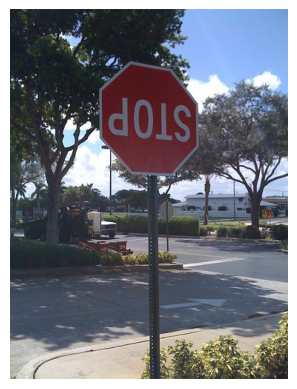

A stop sign is mounted upside-down on it's post. 
A stop sign that is hanging upside down.
An upside down stop sign by the road.
a stop sign put upside down on a metal pole 
A stop sign installed upside down on a street corner


In [ ]:
image_id = '000000000724.jpg'
# Visualize the img and its captions
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(val_dataset.img_dir / image_id).convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.show()

cocoval = json.load(open('./annotations/captions_val2017.json'))
for ann in cocoval['annotations']:
    if ann['image_id'] == 724:
        print(ann['caption'])

In [ ]:
emb = val_dataset.embedding_map['000000000724.jpg']
vec2text_model.predict(emb, target_lang='eng_Latn')

['A stop sign installed upside down on a street corner',
 'A stop sign is mounted upside-down on its stand.',
 'A stop sign that is hanging upside down.',
 'An upside down stop sign by the road.',
 'a stop sign put upside down on a metal pole']

In [ ]:
transform = T.Compose([
                T.Resize((224,224)),
                T.ToTensor(),
                T.Normalize(mean=[0.5]*3, std=[0.5]*3),
            ])

img_tensor = transform(img).unsqueeze(0).to(device)
pred_emb = trained_model(img_tensor.to(device))

In [ ]:
# vec2text_model = EmbeddingToTextModelPipeline(decoder="text_sonar_basic_decoder",
#                                               tokenizer="text_sonar_basic_encoder",
#                                               device=torch.device(device),
#                                               dtype=torch.float16)
print(f"Predicted embed type is {pred_emb.dtype}")
vec2text_model.predict(pred_emb.to(torch.float16), target_lang='eng_Latn')

Predicted embed type is torch.float32


['A lioness sitting on a plane.']

In [ ]:
vec2text_model.predict(5*pred_emb.to(torch.float16), target_lang='eng_Latn')

['a paddle']

In [ ]:
pil_images = [to_pil_image(img_tensor.squeeze(0).cpu())]

In [ ]:
# 3) Preprocess for BLIP
inputs = processor(images=pil_images, return_tensors="pt").to(device)

# 4) Generate captions
out_ids = model.generate(
    **inputs,
    max_length=30,
    num_beams=5,
    early_stopping=True
)
captions = processor.batch_decode(out_ids, skip_special_tokens=True)

In [ ]:
captions

['a red stop sign sitting on the side of a road']

### Validate the BLIP

In [ ]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import json

class COCORawCaptionDataset(Dataset):
    def __init__(self, img_dir, coco_json, transform=None, subset=1.0, seed=None):
        self.img_dir = Path(img_dir)
        self.transform = transform or T.Compose([
            T.Resize((224,224)),
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3),
        ])
        with open(coco_json) as f:
            coco = json.load(f)
        from collections import defaultdict
        caps = defaultdict(list)
        for ann in coco["annotations"]:
            key = f"{ann['image_id']:012d}.jpg"
            caps[key].append(ann["caption"])
        self.ids = sorted(caps.keys())
        # optional random subset
        if subset < 1.0:
            import random
            if seed is not None:
                random.seed(seed)
            k = max(1, int(len(self.ids) * subset))
            self.ids = random.sample(self.ids, k)
        self.refs = caps

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_name = self.ids[idx]
        img = Image.open(self.img_dir / img_name).convert("RGB")
        img = self.transform(img)
        return img, self.refs[img_name]


In [ ]:
def collate_captions(batch):
    imgs, caps = zip(*batch)
    imgs = torch.stack(imgs, 0)
    return imgs, list(caps)

raw_val_ds = COCORawCaptionDataset(
    img_dir   = "./data/images/val2017",
    coco_json = "./data/captions_val2017.json",
    subset    = 1.0,
    seed      = 42,
)
raw_val_loader = DataLoader(
    raw_val_ds,
    batch_size   = 4,
    shuffle      = False,
    num_workers  = 4,
    pin_memory   = True,
    collate_fn   = collate_captions,
)

In [ ]:
import torch
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from torchvision.transforms.functional import to_pil_image

@torch.no_grad()
def evaluate_bleu_blip(
    val_loader,       # yields (images, list_of_str_captions)
    processor,
    model,
    device,
    num_batches=None
):
    model.to(device).eval()
    hypotheses, references = [], []
    smooth_fn = SmoothingFunction().method1

    iterator  = val_loader if num_batches is None else itertools.islice(val_loader, num_batches)
    total_it  = len(val_loader) if num_batches is None else num_batches
    pbar      = tqdm(iterator, desc="BLIP Eval", total=total_it)

    for images, ref_lists in pbar:
        # preprocess for BLIP
        pil_imgs = [to_pil_image(img.cpu()) for img in images]
        inputs   = processor(images=pil_imgs, return_tensors="pt").to(device)

        # generate (greedy to save mem)
        out_ids = model.generate(
            **inputs,
            max_length=30,
            num_beams=1,
            early_stopping=True
        )
        preds = processor.batch_decode(out_ids, skip_special_tokens=True)

        # accumulate
        for pred, refs in zip(preds, ref_lists):
            hypotheses.append(pred.split())
            references.append([r.split() for r in refs])

    bleu4 = corpus_bleu(
        references,
        hypotheses,
        weights=(0.25,0.25,0.25,0.25),
        smoothing_function=smooth_fn
    )
    print(f"\nCorpus BLEU-4 = {bleu4:.4f}")
    return bleu4



In [ ]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model     = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

evaluate_bleu_blip(raw_val_loader, processor, model, device, num_batches=50)
